In [9]:
%load_ext autoreload
%autoreload 2
from paths import *

from matplotlib import pyplot as plt
import matplotlib
import torch
from src.SERS_dataset import IterDataset
from src.generate_data2 import pseudoVoigtSimulatorTorch
from src.plotting.save_plot import save_plot
from src.plotting.VAE_plotting import plot_losses_3_2, plt_recons_with_dist, plt_sigma_as_func_of_alpha_and_c
# import make_axes_locatable
import numpy as np
import dill
import io
import time
import pandas as pd



# matplotlib style seaborn-whitegrid
plt.style.use('seaborn-whitegrid')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
cuda = torch.cuda.is_available()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


C:\Users\andre\AppData\Local\Temp\ipykernel_17172\2016126729.py:22: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [10]:
# load model that has been trained on GPU on CPU. Source https://github.com/pytorch/pytorch/issues/16797
class CPU_Unpickler(dill.Unpickler):
    def find_class(self, module, name):
        if module == 'torch.storage' and name == '_load_from_bytes':
            return lambda b: torch.load(io.BytesIO(b), map_location='cpu')
        else: return super().find_class(module, name)

def load_dill(file_name, experiment):
    file_name = os.path.join(results_dir, experiment, file_name)
    with open(file_name, 'rb') as f:
        contents = CPU_Unpickler(f).load()
    autoencoder = contents["model"]
    train_loss = contents["train_loss"]
    generator_num = contents["generator"]

    return autoencoder, train_loss, generator_num

<Figure size 800x550 with 0 Axes>

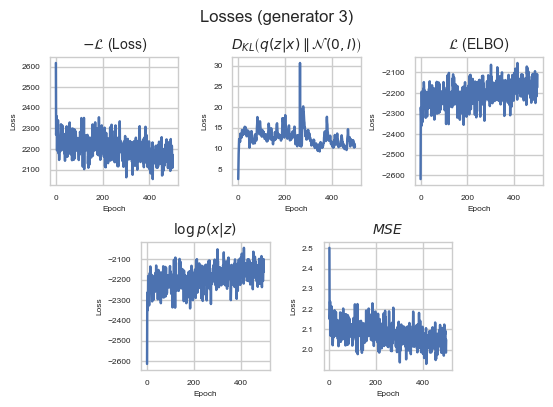

In [12]:
model_name = "civilized-wars-361"
autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_VAE_voigt_decoder")

plot = plot_losses_3_2(train_loss, generator_num, width_in_cm=14.5)
save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_losses_" + "_NO_SIGMOID"), ["pdf", "png"])


In [13]:
models = ["golden-breeze-579", "breezy-darkness-583", "comic-glade-641"]
labels_dict = {1: "alpha", 2: "c", 3: ["c", "alpha"]}

In [19]:
for model_name in models:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_VAE_voigt_decoder")

    ps = pseudoVoigtSimulatorTorch(500)
    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

    times = []
    good_estimate = []

    for i in range(100):
        
        x, y = next(iter(train_loader))
        x = x.to(device)
        y = y.to(device)

        time_start = time.time()
        autoencoder.encode(x)
        time_end = time.time()

        z, mu, logvar = autoencoder.encode(x)


        times.append(time_end - time_start)
        mu_true = torch.stack((y[:,0]/500, y[:,3]), dim=1)[:,:,0]
        mu_true = mu_true.cpu().detach().numpy()
        if generator_num == 3:
            ge = abs(mu.cpu().detach().numpy() - mu_true) < [0.01, 0.1]
            ge_perc = np.sum(np.sum(ge, axis=1) == 2)/100
        elif generator_num == 2:
            ge = abs(mu.cpu().detach().numpy().flatten() - mu_true[:,0]) < 0.01
            ge_perc = np.sum(ge == 1)/100

        elif generator_num == 1:
            ge = abs(mu.cpu().detach().numpy().flatten() - mu_true[:,1]) < 0.1
            ge_perc = np.sum(ge == 1)/100

        good_estimate.append(ge_perc)

    print("Generator number:", generator_num, "(" + model_name + ")")
    print("   Mean inference time for a batch: ", np.mean(times))
    print("   Good estimates: ", np.mean(good_estimate))

Generator number: 1 (golden-breeze-579)
   Mean inference time for a batch:  0.007374272346496582
   Good estimates:  0.6626000000000001
Generator number: 2 (breezy-darkness-583)
   Mean inference time for a batch:  0.01373971700668335
   Good estimates:  0.8842
Generator number: 3 (comic-glade-641)
   Mean inference time for a batch:  0.017371680736541748
   Good estimates:  0.17020000000000002


Generator 1 (golden-breeze-579)
   loss 381.87449784712356
   kl 19.07691140608354
   elbo -381.87449784712356
   logpx -362.797588001598
   MSE 0.2499019286849282
   MSE (mu) 0.25023216009140015 (validation batch)
   MSE (z) 0.250556617975235 (validation batch)

Generator 2 (breezy-darkness-583)
   loss 388.13949307528407
   kl 6.639886292544278
   elbo -388.13949307528407
   logpx -381.49961159446025
   MSE 0.2686039453203028
   MSE (mu) 0.2649804651737213 (validation batch)
   MSE (z) 0.2652541995048523 (validation batch)

Generator 3 (comic-glade-641)
   loss 485.87955821644175
   kl 26.21534590287642
   elbo -485.87955821644175
   logpx -459.66419844193894
   MSE 0.3467685282230377
   MSE (mu) 0.365106999874115 (validation batch)
   MSE (z) 0.5099186897277832 (validation batch)



<Figure size 800x550 with 0 Axes>

<Figure size 551.181x404.199 with 0 Axes>

<Figure size 551.181x551.181 with 0 Axes>

<Figure size 551.181x404.199 with 0 Axes>

<Figure size 551.181x551.181 with 0 Axes>

<Figure size 551.181x404.199 with 0 Axes>

<Figure size 551.181x551.181 with 0 Axes>

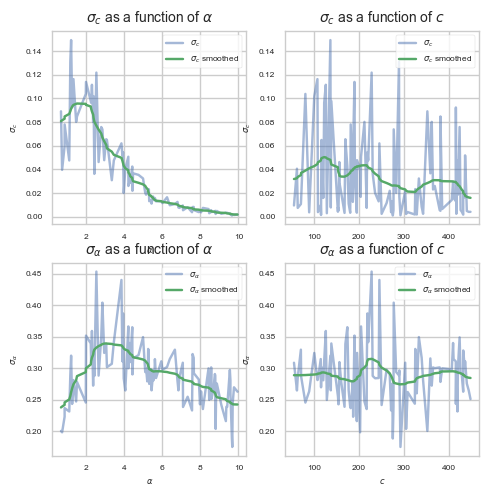

In [15]:
ps = pseudoVoigtSimulatorTorch(500)


loss_names = {"loss": "$-\\mathcal{L}$ (Loss)", "elbo": "$\\mathcal{L}$ (ELBO)", "kl": "$D_{KL}\\left (q(z|x)\\parallel\\mathcal{N}(0,I) \\right)$", "logpx": "$\\log p(x|z)$"}
# reverse dictionary
loss_names_reversed = {val: key for key, val in loss_names.items()}

# Make dataframe for losses, rows are generators and columns are losses
df = pd.DataFrame(columns=["Generator", *[val for key, val in loss_names.items()], "$MSE$ ($\\mu$)", "$MSE$ ($z$)"])


for model_name in models:
    autoencoder, train_loss, generator_num = load_dill(f"{model_name}.dill", "3_VAE_voigt_decoder")
    generator = ps.predefined_generator(generator_num)
    dset_train = IterDataset(generator)
    train_loader = torch.utils.data.DataLoader(dset_train, batch_size=100, pin_memory=cuda)

   


    print("Generator", generator_num, "(" + model_name + ")")
    for key, value in train_loss.items():
        print("  ", key, value[-1])

    x, y = next(iter(train_loader))
    x = x.to(device)
    y = y.to(device)
    z, mu, logvar = autoencoder.encode(x)
    sigma = torch.exp(0.5 * logvar)
    x_hat = autoencoder.decode(z)
    x_hat_mu = autoencoder.decode(mu)

    MSE = torch.nn.MSELoss()
    loss = MSE(x_hat_mu, x)
    print("   MSE (mu)", loss.item(), "(validation batch)")
    loss = MSE(x_hat, x)
    print("   MSE (z)", loss.item(), "(validation batch)")
    print()

    df.loc[len(df)] = [generator_num, *[train_loss[loss][-1] for loss in loss_names_reversed.values()], 
                       MSE(x_hat_mu, x).item(), MSE(x_hat, x).item()]

    x = x.cpu().detach().numpy()
    x_hat = x_hat.cpu().detach().numpy()
    x_hat_mu = x_hat_mu.cpu().detach().numpy()
    sigma = sigma.cpu().detach().numpy()
    mu = mu.cpu().detach().numpy()
    z = z.cpu().detach().numpy()

    

    # recons = autoencoder.decode(z)
    label = labels_dict[generator_num]

    ll = {"c": 0, "gamma": 1, "eta": 2, "alpha": 3}
    labels = []
    if isinstance(label, list):
        for l in label:
            labels.append(y[:,ll[l]])
    else:
        labels.append(y[:,ll[label]])
        label = [label]

    plot =  plot_losses_3_2(train_loss, 3, width_in_cm=14.5)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_losses_" + "_".join(label)), ["pdf", "png"])
    plot = plt_recons_with_dist(x, x_hat_mu, mu, sigma, y, generator_num, 2, 2, width_in_cm=14.5)
    save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_reconstructions_" + "_".join(label)), ["pdf", "png"])
    if generator_num == 3:
        plot = plt_sigma_as_func_of_alpha_and_c(mu, sigma, y, width_in_cm=10)
        save_plot(plot, os.path.join(report_dir, "figures", "results", "3_VAE_voigt", "vae_voigt_sigmas_" + "_".join(label)), ["pdf", "png"])

<Figure size 800x550 with 0 Axes>

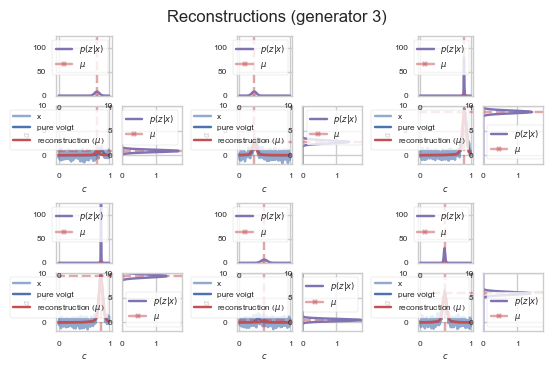

In [18]:
plot = plt_recons_with_dist(x, x_hat_mu, mu, sigma, y, generator_num, 2, 2, width_in_cm=14.5)


In [5]:
df = df.round(2)
df = df.reset_index(drop=True)
# Round generator number to 0
df["Generator"] = df["Generator"].astype(int)
# Make latex table 
print(df.to_latex(escape=False, index=False, column_format="r|rrrrrr", float_format="{:0.2f}".format).replace("\\toprule", "").replace("\\bottomrule", "").replace("\\midrule", "\\hline"))

\begin{tabular}{r|rrrrrr}

 Generator &  $-\mathcal{L}$ (Loss) &  $\mathcal{L}$ (ELBO) &  $D_{KL}\left (q(z|x)\parallel\mathcal{N}(0,I) \right)$ &  $\log p(x|z)$ &  $MSE$ ($\mu$) &  $MSE$ ($z$) \\
\hline
         1 &                 381.87 &               -381.87 &                                              19.08 &        -362.80 &           0.25 &         0.25 \\
         2 &                 388.14 &               -388.14 &                                               6.64 &        -381.50 &           0.27 &         0.27 \\
         3 &                 485.88 &               -485.88 &                                              26.22 &        -459.66 &           0.34 &         0.46 \\

\end{tabular}



C:\Users\andre\AppData\Local\Temp\ipykernel_8100\2921890380.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex(escape=False, index=False, column_format="r|rrrrrr", float_format="{:0.2f}".format).replace("\\toprule", "").replace("\\bottomrule", "").replace("\\midrule", "\\hline"))


<module 'matplotlib.pyplot' from 'c:\\Users\\andre\\OneDrive - Danmarks Tekniske Universitet\\Bachelorprojekt\\Code\\bachelor-project\\lib\\site-packages\\matplotlib\\pyplot.py'>

<Figure size 800x550 with 0 Axes>

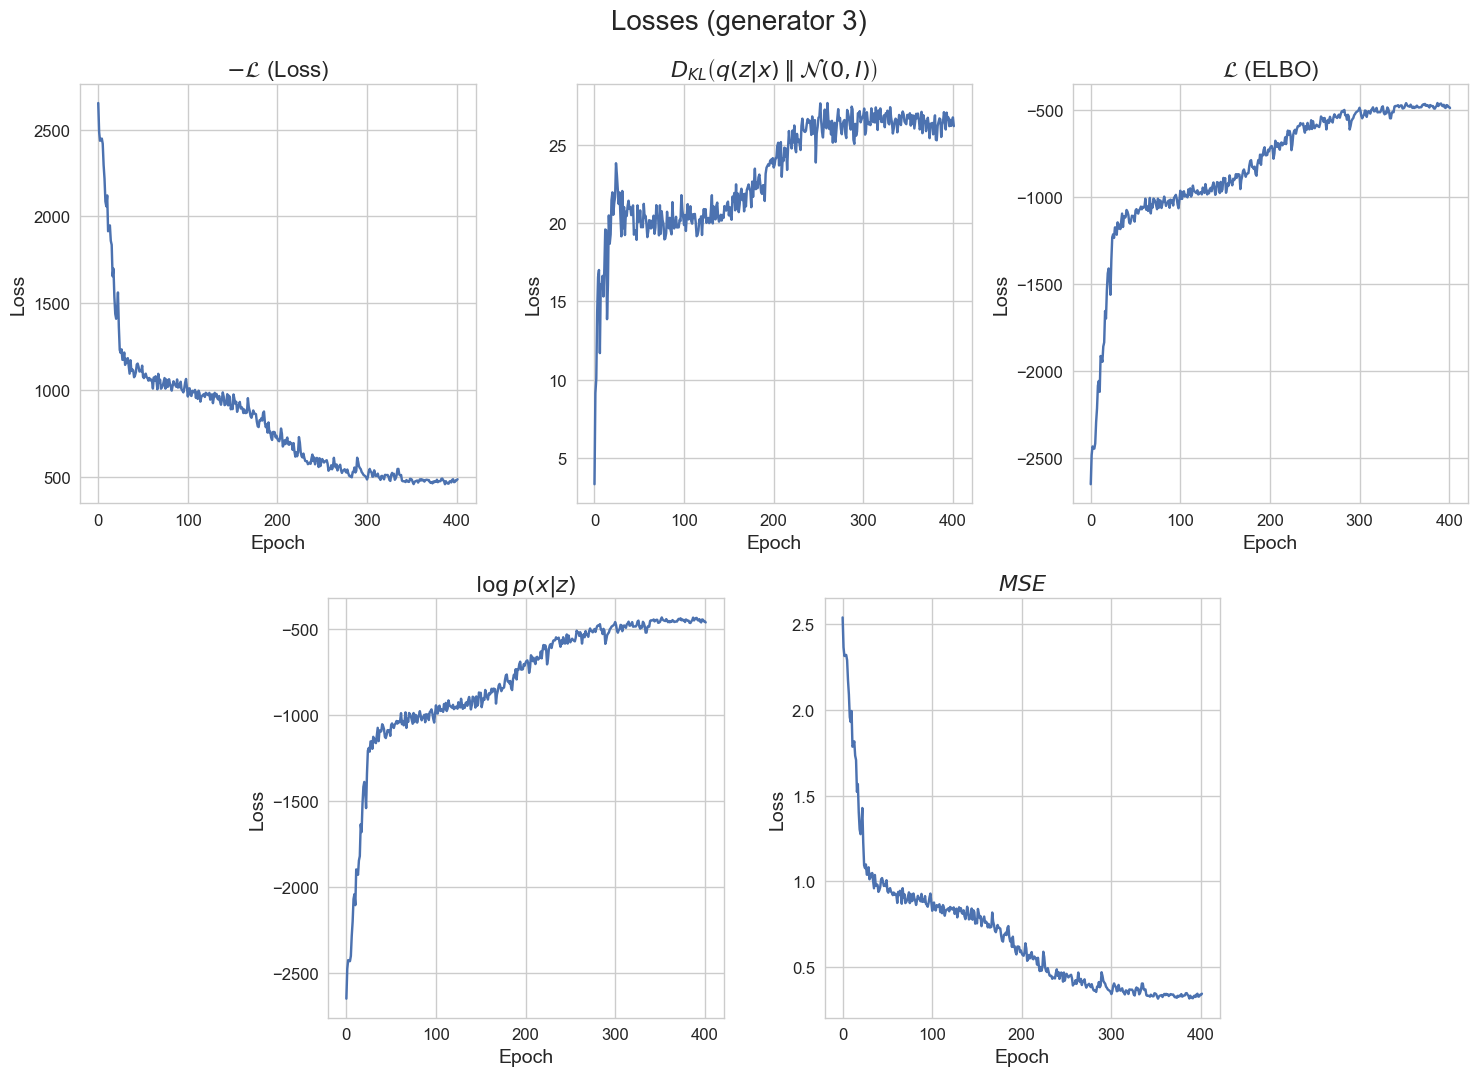

In [28]:
plot_losses_3_2(train_loss, 3)